# Отток клиентов.

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [2]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
pd.options.mode.chained_assignment = None

In [3]:
# чтение файла и печать общей информации
df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# получение первых 5 строк таблицы
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
# в столбце 'Tenure' заменим пропуски на 0 так вероятнее всего пропуск свидетельствует о том, что недвижимости нет
df['Tenure'] = df['Tenure'].fillna(0).astype('int')

# фамилии клиентов и индекс строки в данных не столь важны их можно ужалить каждый клиент идентифицируется по CustomerId
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

# кодирование данных
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [7]:
# разделение на 2 выборки (обучающая и валидационная)
df_train, df_valid = train_test_split(data_ohe, test_size=0.1, random_state=12345)

# размер таблицы
data_ohe.shape

(10000, 12)

In [8]:
print('Кол-во строк в обучающей выборке:', df_train.shape[0])
print('Кол-во строк в валидационной выборке:', df_valid.shape[0])

Кол-во строк в обучающей выборке: 9000
Кол-во строк в валидационной выборке: 1000


In [9]:
# добавил 3ю выборку для теста, того же размера, что и валидационная
df_test_size = df_valid.shape[0] / df_train.shape[0]
df_train, df_test = train_test_split(df_train, test_size=df_test_size, random_state=12345)

print('Кол-во строк в обучающей выборке:', df_train.shape[0])
print('Кол-во строк в валидационной выборке:', df_valid.shape[0])
print('Кол-во строк в тестовой выборке:', df_test.shape[0])

# разделение на обучающие признаки и целевые
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

Кол-во строк в обучающей выборке: 8000
Кол-во строк в валидационной выборке: 1000
Кол-во строк в тестовой выборке: 1000


In [10]:
# масштабирование признаков
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

----------
## Вывод:

На данном этапе я обработал пропуски, также, подготовил признаки и масштабировал цифровые признаки.
    
---------

# 2. Исследование задачи

In [11]:
# проверка сбалансированности
df['Exited'].value_counts(normalize= True) 

0    0.7963
1    0.2037
Name: Exited, dtype: float64

<font color='green'>Наблюдается дисбаланс. </font>


###  LogisticRegression

In [12]:
# обучение модели и проверка на валидационной выбоки
model_LogisticRegression = LogisticRegression(random_state=12345,
                           solver='liblinear'
                          )
model_LogisticRegression.fit(features_train, target_train)
predicted_valid = model_LogisticRegression.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_LogisticRegression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.28070175438596495
AUC ROC: 0.768706445482062


### DecisionTreeClassifier

In [13]:
# обучение модели и проверка на валидационной выбоки
model_DecisionTree = DecisionTreeClassifier(random_state=12345)
model_DecisionTree.fit(features_train, target_train)
predicted_valid = model_DecisionTree.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))
probabilities_valid = model_DecisionTree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.4976958525345622
AUC ROC: 0.678652713578451


In [14]:
# разбиение на подвыборки для кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=12345)

In [22]:
# авоматизизированный перебор параметрров для проверки результата с помощью GridSearchCV
parameters = {'max_depth': range(1, 50)}
gs = GridSearchCV(DecisionTreeClassifier(random_state=12345), 
                  parameters,
                  cv=cv,
                  scoring='f1')

# обучение
gs.fit(features_train, target_train)
# просмотр лучших параметров
gs.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

{'max_depth': 5}

In [23]:
# лучший результат
gs.best_score_

0.5791234846891512

### RandomForestClassifier

In [15]:
model_RandomForest = RandomForestClassifier(random_state=12345)
model_RandomForest.fit(features_train, target_train)       
predictions = model_RandomForest.predict(features_train)
predicted_valid = model_RandomForest.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_RandomForest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.5568181818181818
AUC ROC: 0.8185727023158685


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
# авоматизизированный перебор параметрров для проверки результата с помощью GridSearchCV
parameters = {'max_depth': [3, 4, 6, 10, 14, 21],
             'n_estimators' : range(1, 50)
             }

gs = GridSearchCV(RandomForestClassifier(random_state=12345), 
                  parameters,
                  cv=cv,
                  scoring='f1')

# обучение
gs.fit(features_train, target_train)
# просмотр лучших параметров
gs.best_params_

{'max_depth': 21, 'n_estimators': 37}

In [28]:
# лучший результат
gs.best_score_

0.5877472676854203

----------
## Вывод:

Проверка баланса классов показал что есть большой дисбаланс классов, примерно в 4 раза.

Также на даллном этапе проверил работу моделей.  На данном этапе не получилось достичь заданного значения f1.

Сбалансируем данные и проверим работу моделей.
    
---------

# 3. Борьба с дисбалансом

In [16]:
# формула для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# увеличение обучающей выбоки
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# проверка размера после upsample
features_zeros = features_upsampled[target_upsampled == 0]
features_ones = features_upsampled[target_upsampled == 1]
target_zeros = features_upsampled[target_upsampled == 0]
target_ones = features_upsampled[target_upsampled == 1]

print(features_zeros.shape[0])
print(features_ones.shape[0])

6387
6452


In [17]:
# формула для увеличения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# 
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

# проверка размера после upsample
features_zeros = features_downsampled[target_downsampled == 0]
features_ones = features_downsampled[target_downsampled == 1]
target_zeros = features_downsampled[target_downsampled == 0]
target_ones = features_downsampled[target_downsampled == 1]

print(features_zeros.shape[0])
print(features_ones.shape[0])

1597
1613


###  LogisticRegression

In [18]:
# обучение модели и проверка на валидационной выбоки на сбалансированных данных
model_LogisticRegression = LogisticRegression(random_state=12345,
                           solver='liblinear'
                          )
model_LogisticRegression.fit(features_upsampled, target_upsampled)
predicted_valid = model_LogisticRegression.predict(features_valid)

probabilities_valid = model_LogisticRegression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))


AUC ROC: 0.7742673455501068
F1: 0.5183946488294314


In [19]:
model_LogisticRegression = LogisticRegression(random_state=12345,
                           solver='liblinear'
                          )
model_LogisticRegression.fit(features_downsampled, target_downsampled)
predicted_valid = model_LogisticRegression.predict(features_valid)

probabilities_valid = model_LogisticRegression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

AUC ROC: 0.7728653886764121
F1: 0.5033557046979865


На сбалансированных данных модель показывает результат лучше, продолжим обучение модели и подбор гипперпараметров на сбалансированных данных

### DecisionTreeClassifier

In [20]:
# обучение модели и проверка на валидационной выбоки на сбалансированных данных
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model_DecisionTree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

AUC ROC: 0.678652713578451
F1: 0.46698113207547165


In [21]:
# обучение модели и проверка на валидационной выбоки на сбалансированных данных
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model_DecisionTree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

AUC ROC: 0.678652713578451
F1: 0.5


На сбалансированных данных модель показывает результат лучше, продолжим обучение модели и подбор гипперпараметров на сбалансированных данных При этом на уменьшенной выборке качество лучше.

In [24]:
# проведем перебор параметров и обучение модели с помледующей проверкой результатов
for depth in range(1, 25):
    model_DecisionTree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_DecisionTree.fit(features_upsampled, target_upsampled)
    predictions = model_DecisionTree.predict(features_train)
    scores = cross_val_score(model_DecisionTree, features_train, target_train, cv=cv, scoring='f1').mean()   
    print("max_depth =", depth, ":")
    print("Результат проверки на обучающей  выборке", f1_score(target_train, predictions))
    predictions = model_DecisionTree.predict(features_valid)
    print("Результат проверки на валидационной выборке", f1_score(target_valid, predictions))
    print("Результат проверки при кросс-валидации", scores)
    print()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

max_depth = 1 :
Результат проверки на обучающей  выборке 0.4820143884892086
Результат проверки на валидационной выборке 0.5201465201465202
Результат проверки при кросс-валидации 0.0

max_depth = 2 :
Результат проверки на обучающей  выборке 0.51002331002331
Результат проверки на валидационной выборке 0.5474060822898033
Результат проверки при кросс-валидации 0.5118684289443258

max_depth = 3 :
Результат проверки на обучающей  выборке 0.51002331002331
Результат проверки на валидационной выборке 0.5474060822898033
Результат проверки при кросс-валидации 0.397999272897576

max_depth = 4 :
Результат проверки на обучающей  выборке 0.5482233502538071
Результат проверки на валидационной выборке 0.6075949367088607
Результат проверки при кросс-валидации 0.49932632097928165

max_depth = 5 :
Результат проверки на обучающей  выборке 0.5662360411648785
Результат проверки на валидационной выборке 0.578397212543554
Результат проверки при кросс-валидации 0.5791234846891512

max_depth = 6 :
Результат пров

In [25]:
# настройка модели исходя из тестов
model_DecisionTree = DecisionTreeClassifier(random_state=12345, max_depth=6)
model_DecisionTree.fit(features_upsampled, target_upsampled)
predictions_valid_DT = model_DecisionTree.predict(features_valid)

probabilities_valid = model_DecisionTree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predictions_valid_DT))

AUC ROC: 0.8388453506651962
F1: 0.5985915492957746


----------
При большом колличестве деревьев модель сильно переобучивается и показывает очень хорошие результатты на обучающей выборки и плохие на валидационной.

При ручном подборе гипперпараметров наилучший результат по валидационной выборке был при max_depth=6.
    
---------

### RandomForestClassifier

In [26]:
# обучение модели и проверка на валидационной выбоки на сбалансированных данных
model_RandomForest = RandomForestClassifier(random_state=12345)
model_RandomForest.fit(features_upsampled, target_upsampled)       
predictions = model_RandomForest.predict(features_train)
predicted_valid = model_RandomForest.predict(features_valid)

probabilities_valid = model_RandomForest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))
print(f1_score(target_valid, predicted_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC ROC: 0.8406168610244258
0.5984251968503936


In [29]:
# проведем перебор параметров и обучение модели с помледующей проверкой результатов
for estim in range(15, 35):
    model_RandomForest = RandomForestClassifier(random_state=12345, max_depth=21, n_estimators=estim)
    model_RandomForest.fit(features_upsampled, target_upsampled)       
    predictions = model_RandomForest.predict(features_train)
    scores = cross_val_score(model_RandomForest, features_train, target_train, cv=cv, scoring='f1').mean()   
    print("n_estimators =", estim, ": ")
    print("Результат проверки на обучающей  выборке", f1_score(target_train, predictions))
    predictions = model_RandomForest.predict(features_valid)
    print("Результат проверки на валидационной выборке", f1_score(target_valid, predictions))
    print("Результат проверки при кросс-валидации", scores)
    print()

n_estimators = 15 : 
Результат проверки на обучающей  выборке 0.9975262832405689
Результат проверки на валидационной выборке 0.5905707196029776
Результат проверки при кросс-валидации 0.5773179913792441

n_estimators = 16 : 
Результат проверки на обучающей  выборке 0.9978348283328178
Результат проверки на валидационной выборке 0.5854922279792746
Результат проверки при кросс-валидации 0.5636808459685752

n_estimators = 17 : 
Результат проверки на обучающей  выборке 0.9972179289026275
Результат проверки на валидационной выборке 0.594059405940594
Результат проверки при кросс-валидации 0.5756510079531066

n_estimators = 18 : 
Результат проверки на обучающей  выборке 0.9984524914887032
Результат проверки на валидационной выборке 0.5751295336787563
Результат проверки при кросс-валидации 0.5725352765464582

n_estimators = 19 : 
Результат проверки на обучающей  выборке 0.9981435643564356
Результат проверки на валидационной выборке 0.5975308641975309
Результат проверки при кросс-валидации 0.5761

In [30]:
# настройка модели исходя из тестов
model_RandomForest = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=21)
model_RandomForest.fit(features_upsampled, target_upsampled)
predictions_valid_RF = model_RandomForest.predict(features_valid)

probabilities_valid = model_RandomForest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predictions_valid_RF))

AUC ROC: 0.8585783336070767
0.6311475409836066


{'RandomForestClassifier': 0.5578894042465472, 'DecisionTree': 0.5456403829094709, 'LogisticRegression': 0.3013954402980488}


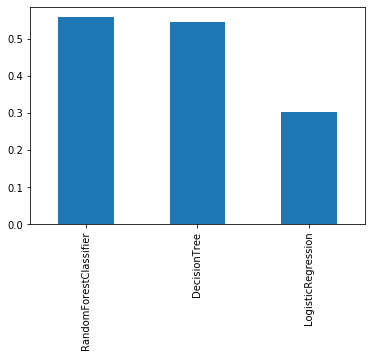

In [31]:
itog_val = {} #словарь для записи результатов кросс валидации разных алгоритмов
scores = cross_val_score(model_RandomForest, features_train, target_train, cv=cv, scoring='f1')
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_DecisionTree, features_train, target_train, cv=cv, scoring='f1')
itog_val['DecisionTree'] = scores.mean()
scores = cross_val_score(model_LogisticRegression, features_train, target_train, cv=cv, scoring='f1')
itog_val['LogisticRegression'] = scores.mean()
print(itog_val)

pd.DataFrame.from_dict(data=itog_val, orient='index').plot(kind='bar', legend=False)

----------
## Вывод:

На данном этапе я обучил и проверил работу 3 моделей, также проверил данные на валиджационной выборке.

Желаемый результат получилось достичь только с помощью RandomForestClassifier.

На следующем этапе проведем ещё одно тестирование на тестовой выборке и проверим модели на адекватность.
    
---------

# 4. Тестирование модели

In [32]:
test_score = {}

### LogisticRegression

In [33]:
# Проверка рещуьтатов на тестовой выборке
predictions_test_LR = model_LogisticRegression.predict(features_test)
f1 = f1_score(target_test, predictions_test_LR)
print(f1)

probabilities_test = model_LogisticRegression.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)
test_score['LogisticRegression'] = [f1 , auc_roc]

0.4991452991452992
0.7825071531632878


### DecisionTreeClassifier

In [34]:
# Проверка рещуьтатов на тестовой выборке
predictions_test_DT = model_DecisionTree.predict(features_test)
f1 = f1_score(target_test, predictions_test_DT)
print(f1)

probabilities_test = model_DecisionTree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)
test_score['DecisionTreeClassifier'] = [f1 , auc_roc]

0.5660377358490567
0.8409949622166247


### RandomForestClassifier

In [35]:
# Проверка рещуьтатов на тестовой выборке
predictions_test_RF = model_RandomForest.predict(features_test)
f1 = f1_score(target_test, predictions_test_RF)
print(f1)

probabilities_test = model_RandomForest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)
test_score['RandomForestClassifier'] = [f1 , auc_roc]

0.5933609958506224
0.8565454500990438


### Проверка на адекватность

[0.3416252072968491, 0.2950354609929078, 0.3225806451612903]


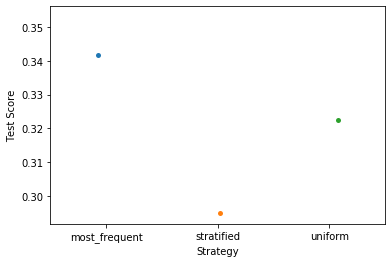

In [36]:
strategies = ['most_frequent', 'stratified', 'uniform']
test_scores = []

for s in strategies:
    dummy_clf = DummyClassifier(strategy=s, random_state=12345)
    dummy_clf.fit(features_upsampled, target_upsampled)
    score = dummy_clf.score(features_test,  target_test)
    predict = dummy_clf.predict(features_test)
    f1 = f1_score(target_test, predict)
    test_scores.append(f1)
    
print(test_scores)
ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Strategy', ylabel ='Test Score')
plt.show()

In [37]:
columns = ['F1', 'AUC']
df_score = pd.DataFrame.from_dict(data=test_score, columns=columns, orient='index')
df_score

,F1,AUC
LogisticRegression,0.499145,0.782507
DecisionTreeClassifier,0.566038,0.840995
RandomForestClassifier,0.593361,0.856545


----------
## Общий вывод:

Проверка на адекватность показала,что результат работы обченной модели лучше случайных результатов.

Лучший результат показвыаает модель RandomForest результат на тестовой выборке 0.59, на валидационной 0,64
Хорошее качество модели также подтверждает и AUC-ROC 0.86. Максимальный среди всех моделей.
    
---------

<font color='green'>Лучшая модель выбирается по качеству на валидационной выборке, поэтому итоговая модель – RandomForest, обученный на выборке после upsampling. Качество этой модели на тестовой выборке – 0.59, значит, требование задачи выполнено.</font>


# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*